In [34]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib as mpl
import datetime
from dotenv import load_dotenv
from dash import Dash, dcc, html, Output, Input,ctx
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import csv
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import plotly.tools as tls
import mpld3

import math


load_dotenv();

In [2]:
def make_pretty(styler):
    styler.set_caption("When do I listen to songs?")
    styler.hide()
    return styler

In [3]:
history = pd.read_csv(os.getenv("SONGHISTORY_CSV"),index_col=0)
art_song = pd.read_csv(os.getenv("ARTISTS_SONGS_CSV"),index_col=0)
songs = pd.read_csv(os.getenv("SONGS_CSV"),index_col=0)
artists = pd.read_csv(os.getenv("ARTISTS_CSV"),index_col=0)

In [4]:
# Preliminary cleaning 
history.drop(columns=['preview_url'],inplace=True)
history.drop_duplicates(inplace=True)
## TODO - FIX PROBLEM OF THE BACK TO BACK DUPLICATES

In [5]:
def account_for_germany(x):
    if x.replace(tzinfo=None) < datetime.datetime(year=2025,month=8,day=9,hour=18):
        return x + datetime.timedelta(hours=1)
    return x

In [6]:
# history is purely for August + fixed for Germany
history = pd.read_csv(os.getenv("SONGHISTORY_CSV"),index_col=0)
history['played_at'] = pd.to_datetime(history['played_at'])
history = history[history['played_at'].dt.date > datetime.datetime(year=2025,month=8,day=1).date()]
history['played_at'] = history['played_at'].apply(lambda x : account_for_germany(x))

In [7]:
history.columns

Index(['available_markets', 'disc_number', 'duration_ms', 'explicit',
       'external_urls', 'href', 'id', 'is_local', 'name', 'popularity',
       'preview_url', 'track_number', 'type', 'uri', 'album_id', 'isrc',
       'context', 'played_at'],
      dtype='object')

In [8]:
time_s = (songs['duration_ms'].mean()/1000)
print(f"Average liked song duration:  {int(time_s // 60)}m {round(time_s % 60)}s")
## do min max and average song lenght using agg

Average liked song duration:  3m 43s


In [9]:
# Artists which appear most frequently in liked songs
grouped_by_artists = art_song.groupby(by=["ArtistId"])
most_popular = grouped_by_artists['SongId'].count().nlargest(n=20).reset_index()
artists_names = artists[['name','id']].drop_duplicates()
x = pd.merge(left=artists_names,right=most_popular, left_on='id',right_on='ArtistId',how='right').drop(columns=['ArtistId','id'])
x = x.rename(columns={'name':'Artists Name', 'SongId' : 'No. of songs'})
x.style.hide()

Artists Name,No. of songs
Barrett Wilbert Weed,12
Original Broadway Cast of Mean Girls,11
The Beatles,10
Erika Henningsen,10
Sam Fender,9
Stromae,8
Lady Gaga,6
Twenty One Pilots,6
Rihanna,6
Lyn,6


In [10]:
# Most listened to songs in August
x = history.groupby(by=['id','name']).size().reset_index().rename(columns={0:'No. of listens','name' : 'Song Name'}).drop(columns=['id'])
x = x.sort_values(by='No. of listens',ascending=False)
x.head(10).style.hide()

Song Name,No. of listens
Sweet Talk,37
Everybody Talks,33
Tongue Tied,26
"Du (Was ich will, bist du)",25
Hard Times,23
Put Your Records On,21
Teenagers,18
Comeback Kid,18
Charlemagne,16
Complicated,15


In [11]:
# total count, no. of songs listened to per hour
history['hour_played'] = history['played_at'].apply(lambda x: x.hour)
counts = history['hour_played'].value_counts().reset_index()
x = pd.merge(left=pd.Series(np.arange(0,24),name="Hour"),right=counts,left_on="Hour",right_on='hour_played',how='left').fillna(0).astype(int)[['Hour','count']].rename(columns={'count' : 'No. of songs'})
x['Hour'] = x['Hour'].apply(lambda x: f"{x:02d}:00")
x.style.hide()

Hour,No. of songs
00:00,8
01:00,1
02:00,0
03:00,0
04:00,0
05:00,0
06:00,0
07:00,12
08:00,82
09:00,74


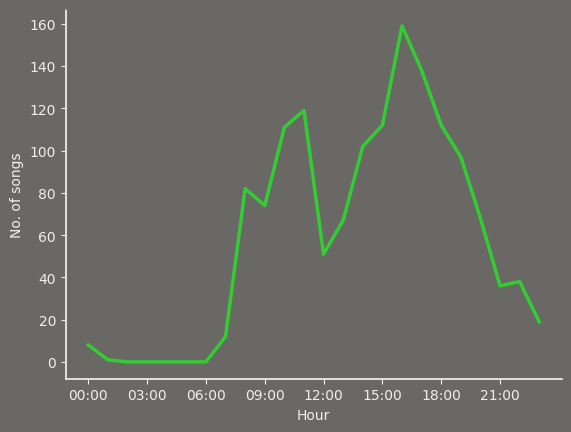

In [12]:
LGREY = "#f0efed"

ax = sns.lineplot(data=x,x='Hour',y='No. of songs',linewidth=2.5,color="#32cd32")
plt.xticks(list(map(lambda x: f"{x:02d}:00",np.arange(0,24,3))));

ax.spines[['top','right']].set_color('#696865')
ax.spines[['bottom','left']].set_color(LGREY)
ax.spines[['top','right','bottom','left']].set_linewidth(1.25) 
ax.xaxis.label.set_color(LGREY)
ax.yaxis.label.set_color(LGREY)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_color(LGREY)
ax.tick_params(colors=LGREY)
ax.set_facecolor('#696865')
fig = ax.get_figure()
fig.set_facecolor('#696865')

plt.show()
# mpld3.save_html(fig,'clean')

In [13]:

LGREY = "#f0efed"
LIMEGREEN = "#32cd32"
DGREY = "#696865"
max_val = x['No. of songs'].max()

# Build the line plot
fig = px.line(
    data_frame = x,
    x=x["Hour"], 
    y=x["No. of songs"],
    labels={"x": "Hour", "y": "No. of songs"},
)

# Style the trace
fig.update_traces(line=dict(color=LIMEGREEN, width=2.5))

# Format the layout to match your matplotlib look
fig.update_layout(
    paper_bgcolor=DGREY,   # figure background
    plot_bgcolor=DGREY,    # axes background
    font=dict(color=LGREY),    # text color
    xaxis=dict(
        showline=True, 
        showgrid=False,
        zeroline=False,
        linecolor=LGREY,
        tickvals=np.arange(0, 24, 3),
        ticktext=[f"{h:02d}:00" for h in np.arange(0, 24, 3)],
        tickfont=dict(color=LGREY,weight='bold'),
        title=dict(text="Hour", font=dict(color=LGREY,weight='bold'))
    ),
    yaxis=dict(
        showline=True, 
        showgrid=False,
        zeroline=False,
        linecolor=LGREY,
        tickfont=dict(color=LGREY,weight='bold'),
        title=dict(text="No. of songs", font=dict(color=LGREY,weight='bold')),
        range = [-5,max_val+10]
    )
)

In [14]:
def week_calc(x):
    if  x.replace(tzinfo=None) < datetime.datetime(year=2025,month=8,day=8,hour=23,minute=59,second=59):
        return 1
    elif x.replace(tzinfo=None) < datetime.datetime(year=2025,month=8,day=15,hour=23,minute=59,second=59):
        return 2
    elif x.replace(tzinfo=None) < datetime.datetime(year=2025,month=8,day=22,hour=23,minute=59,second=59):
        return 3
    elif x.replace(tzinfo=None) < datetime.datetime(year=2025,month=8,day=29,hour=23,minute=59,second=59):
        return 4
    elif x.replace(tzinfo=None) < datetime.datetime(year=2025,month=8,day=31,hour=23,minute=59,second=59) : 
        return 5

In [15]:
# week-by-week, no. of songs listened to per hour
week_df = history.copy()
week_df['week'] = week_df['played_at'].apply(lambda x: week_calc(x))
grouped_week = week_df.groupby(by=['week','hour_played'])
counts = grouped_week['id'].count().reset_index().rename(columns={'week': 'Week', 'hour_played': 'Hour'})
all_hours = pd.merge(left=pd.Series([1,2,3,4,5],name="Week"),right=pd.Series(np.arange(0,24),name="Hour"),how='cross')
counts_full = pd.merge(left=all_hours,right=counts,on=["Week","Hour"],how='left')
counts_full['No. of Songs'] = counts_full['id'].fillna(0).astype(int)
counts_full['Week'] = counts_full['Week'].astype(str)
counts_full['Hour'] =  counts_full['Hour'].apply(lambda x: f"{x:02d}:00")

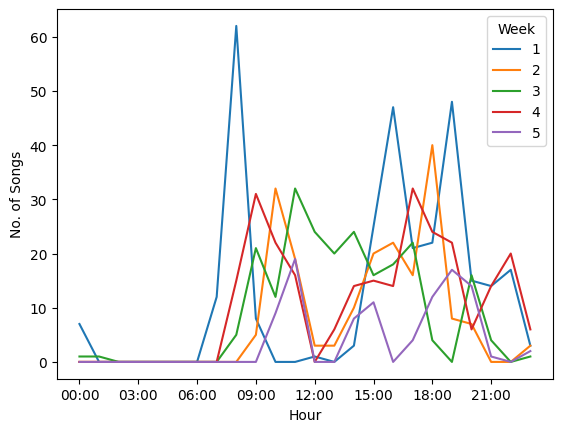

In [16]:
sns.lineplot(data=counts_full,x='Hour',y='No. of Songs',hue='Week')
plt.xticks(list(map(lambda x: f"{x:02d}:00",np.arange(0,24,3))));

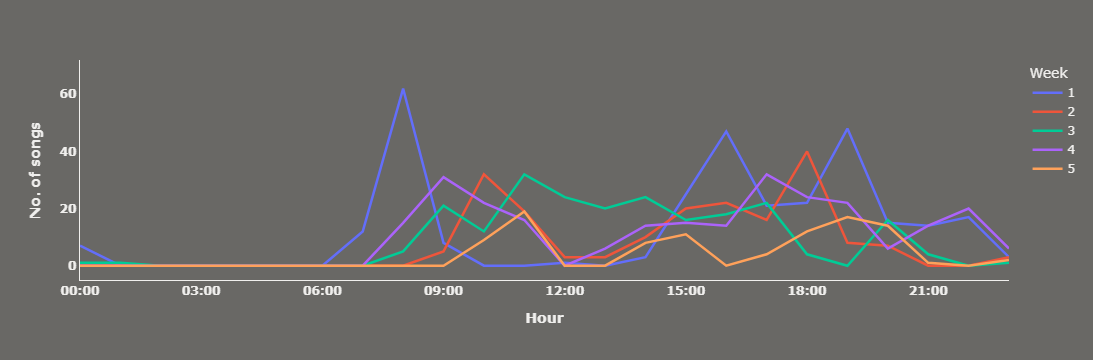

In [17]:
LGREY = "#f0efed"
LIMEGREEN = "#32cd32"
DGREY = "#696865"
max_val = counts_full['No. of Songs'].max()

# Build the line plot
fig = px.line(
    data_frame = counts_full,
    x="Hour", 
    y="No. of Songs",
    color="Week",
    labels={"x": "Hour", "y": "No. of songs"},
)

# # Style the trace
fig.update_traces(line=dict(width=2.5))

# Format the layout to match your matplotlib look
fig.update_layout(
    paper_bgcolor=DGREY,   # figure background
    plot_bgcolor=DGREY,    # axes background
    font=dict(color=LGREY),    # text color
    xaxis=dict(
        showline=True, 
        showgrid=False,
        zeroline=False,
        linecolor=LGREY,
        tickvals=np.arange(0, 24, 3),
        ticktext=[f"{h:02d}:00" for h in np.arange(0, 24, 3)],
        tickfont=dict(color=LGREY,weight='bold'),
        title=dict(text="Hour", font=dict(color=LGREY,weight='bold'))
    ),
    yaxis=dict(
        showline=True, 
        showgrid=False,
        zeroline=False,
        linecolor=LGREY,
        tickfont=dict(color=LGREY,weight='bold'),
        title=dict(text="No. of songs", font=dict(color=LGREY,weight='bold')),
        range = [-5,max_val+10]
    )
)

In [18]:
def colour_picker(df,text):
    if text == "":
        return "rgba(80, 89, 91, 0.89)"
    else:
        try: 
            watches = int(df.loc[text])
            if watches == 1:
                return "rgba(49, 235, 65, 0.78)"
            return "rgba(0, 144, 13, 1)"
        except KeyError:
            return "rgba(240,240,240,1)"
        

In [19]:
def initialise_graph_extras(fig,song_id,date):
    week_days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    song_name = songs.loc[songs['id'] == song_id, 'name']
    date = datetime.datetime.strptime(date,"%Y-%m-%dT%H:%M:%S.%f")
    
    if not song_name.empty:
        artist_ids = art_song.loc[art_song['SongId'] == song_id, 'ArtistId']
        artists_names = artists.loc[artists['id'].isin(artist_ids),'name'].drop_duplicates().to_list()
        artists_str = ", ".join(artists_names)
        total_str = f"Listening History :  {song_name.item()} by " + artists_str
        if len(total_str) > 65:
            total_str  = total_str[0:62] + "..."
            
        fig.add_shape(
            type="rect",
            x0=0, y0=18, x1=5, y1=19.5,
            line=dict(width=0),
            fillcolor="rgba(255, 255, 255, 0.59)",
            label=dict(text=total_str, 
                       textposition="middle left", font=dict(family="Souvenir Lt BT, bold", size=28))
        )

    
    fig.add_shape(
        type="rect",
        x0=0, y0=15, x1=5, y1=16.5,
        line=dict(width=0),
        fillcolor="rgba(255, 255, 255, 0.59)",
        label=dict(text=f"{date.strftime('%B').upper()} {date.strftime('%Y').upper()}", textposition="middle left", font=dict(family="Souvenir Lt BT, bold", size=28,color='red'))
    )
        
    for k in range(0,7):
        fig.add_shape(
                type="rect",
                x0=2*k, y0=12, x1=2*k+1.5, y1=13.5, 
                line=dict(color="grey", width=2),
                fillcolor="rgba(49, 206, 235, 0.59)",
                label=dict(text=week_days[k])
            )

In [20]:
def compute_day_labels(fig,date):
    days = [[None,None,None,None,1,2,3],np.arange(4,11),np.arange(11,18),np.arange(18,25),[25,26,27,28,29,30,31]]
    day_labels = np.array(days)
    return day_labels

In [21]:

app = Dash(__name__)
song_choices = list(zip(songs['name'],songs['id']))
fig = go.Figure()
fig.update_xaxes(range = [-1,15],showticklabels=False,showgrid=False,zeroline=False,fixedrange=True)
fig.update_yaxes(range = [-1,20],showticklabels=False,showgrid=False,zeroline = False,fixedrange=True)
fig.update_layout(template='plotly_white')


app.layout = html.Div([
    dcc.Dropdown(
        id='song_choice',
        options=[{'label': song_name, 'value': song_id} for song_name,song_id in song_choices],
        searchable=True
    ),
    html.Button('<',id='back',n_clicks=0),
    html.Button('>',id='forwards',n_clicks=0),
    dcc.Graph(id='graph',config= {'displayModeBar' : False}),
    dcc.Store(id="current_date", data=datetime.datetime.today().replace(day=1))
])

@app.callback(
    Output('graph', 'figure'),
    Input('song_choice', 'value'),
    Input('current_date','data'),
)
def update_graph(song,date):
    fig.layout.shapes = []
    song_history = history[history['id'] == song][['name','played_at']]
    song_history['day'] = song_history['played_at'].apply(lambda x : x.day)
    counts = song_history.groupby(by='day').size()

    day_labels = compute_day_labels(fig,date)
    
    for i in range(0,5):
        for j in range(0,7):
            text = ""
            if day_labels[i][j] is not None:
                text = day_labels[i][j]
                
            fig.add_shape(
                type="rect",
                x0=2*j, y0=10 - 2*i, x1=2*j+1.5, y1=10 -2*i+1.5, 
                line=dict(color="black", width=1),
                fillcolor=colour_picker(counts,text),
                label=dict(text=text)
            )
            
    initialise_graph_extras(fig,song,date)
        
    return fig

@app.callback(
    Output('current_date','data'),
    Input('back','n_clicks'),
    Input('forwards','n_clicks'),
    Input('current_date','data'),
    prevent_initial_call=True
)
def update_month(back,forwards,current_date):
    current_date = datetime.datetime.strptime(current_date,"%Y-%m-%dT%H:%M:%S.%f")
    if "back" == ctx.triggered_id:
        current_date = (current_date - datetime.timedelta(days=1)).replace(day=1)
    elif "forwards" == ctx.triggered_id:
        current_date = (current_date + datetime.timedelta(days=35)).replace(day=1)
    return current_date
    
if __name__ == '__main__':
    app.run(debug=False)

OSError: Address 'http://127.0.0.1:8050' already in use.
    Try passing a different port to run.

In [22]:
def fix(x):
    if x in ['Boston','Seattle','New York']:
        return "United States"
    elif x in ['England','London']:
        return "United Kingdom"
    return x

In [42]:
places_df = pd.read_csv(os.getenv("PLACES_CSV"),index_col=0)
places_df = places_df.drop_duplicates()
places_df['country'] = places_df['country'].apply(lambda x : fix(x))
flat_numbers = places_df[['country']].groupby(['country']).size().to_frame('count').reset_index()
flat_numbers

,country,count
0,Australia,1
1,Austria,1
2,Belgium,1
3,Canada,4
4,France,2
5,Germany,3
6,Ireland,2
7,Jamaica,1
8,Netherlands,1
9,Northern Ireland,1


In [69]:
country_codes = pd.read_csv(r"C:\Users\annab\OneDrive\Documents\coding projects\spotify api\csv\wikipedia-iso-country-codes.csv")
country_codes = country_codes[['English short name lower case','Alpha-3 code']].rename(columns={'English short name lower case':'name','Alpha-3 code' :'code'})
coded_counts = pd.merge(left=country_codes,right=flat_numbers,left_on='name',right_on='country',how='left')[['name','code','count']].fillna(0)
coded_counts['logged_counts'] = coded_counts['count'].apply(lambda x : np.log10(x) if x != 0 else x)

In [24]:
artists_ids = pd.merge(left=songs['id'],right=art_song,left_on='id',right_on='SongId',how='left')['ArtistId']
origins = pd.merge(left=artists_ids,right=places_df,left_on='ArtistId',right_on='id',how='left')
prop_numbers = origins[['country']].groupby(['country']).size()

In [35]:
class toMap:

    def setMap(self):
            # # --- Save Countries, Latitudes and Longitudes ---
            # filename = 'csv/log.csv'
            # cnames, lats, lons = [], [], []
        
            # with open(filename) as f:
            #     reader = csv.reader(f)
            #     next(reader)
            #     for row in reader:
            #         cnames.append(str(row[0]))
            #         lats.append(float(row[1]))
            #         lons.append(float(row[2]))

            self.countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name='admin_0_countries')
            self.cmap = mpl.cm.Blues

        
    def flat_dist(self):
        self.setMap()
        ax = plt.axes(projection=ccrs.Robinson())
        ax.set_title("Distribution of origin of artists listened to")
        top_appearance = flat_numbers.max()
        norm = mcolors.LogNorm(vmin=1, vmax=top_appearance)
        for country in shpreader.Reader(self.countries_shp).records():
            country_name = country.attributes['NAME_LONG']
            if country_name in flat_numbers.index:
                appearances = flat_numbers.loc[country_name]
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor=self.cmap(norm(appearances)),
                                  label=country_name)
    
            else:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor='#FAFAFA',
                                  label=country_name)
                
        print(pio.to_html(tls.mpl_to_plotly(ax.get_figure()), include_plotlyjs='cdn', full_html=False))
        return pio.to_html(tls.mpl_to_plotly(ax.get_figure()), include_plotlyjs='cdn', full_html=False)

    def proportional_dist(self):
        self.setMap()
        ax = plt.axes(projection=ccrs.Robinson())
        ax.set_title("Distribution proportional to number of songs")
        top_appearance = prop_numbers.max()
        norm = mcolors.LogNorm(vmin=1, vmax=top_appearance)
        for country in shpreader.Reader(self.countries_shp).records():
            country_name = country.attributes['NAME_LONG']
            if country_name in prop_numbers.index:
                appearances = prop_numbers.loc[country_name]
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor=self.cmap(norm(appearances)),
                                  label=country_name)
    
            else:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                  facecolor="#FCEBEB",
                                  label=country_name)

    
        plt.show()
        
        


In [61]:
# m = toMap()
# m.flat_dist()
# # m.proportional_dist()

In [71]:
fig = px.choropleth(coded_counts, locations="code",
                    color="logged_counts", # lifeExp is a column of gapminder
                    hover_name="name", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
pio.to_html(fig, include_plotlyjs='cdn', full_html=False)

'<div>                        <script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: \'local\'};</script>\n        <script charset="utf-8" src="https://cdn.plot.ly/plotly-3.0.1.min.js" integrity="sha256-oy6Be7Eh6eiQFs5M7oXuPxxm9qbJXEtTpfSI93dW16Q=" crossorigin="anonymous"></script>                <div id="3d244296-758e-4c64-a2ae-ca179031e2a5" class="plotly-graph-div" style="height:100%; width:100%;"></div>            <script type="text/javascript">                window.PLOTLYENV=window.PLOTLYENV || {};                                if (document.getElementById("3d244296-758e-4c64-a2ae-ca179031e2a5")) {                    Plotly.newPlot(                        "3d244296-758e-4c64-a2ae-ca179031e2a5",                        [{"coloraxis":"coloraxis","geo":"geo","hovertemplate":"\\u003cb\\u003e%{hovertext}\\u003c\\u002fb\\u003e\\u003cbr\\u003e\\u003cbr\\u003ecode=%{location}\\u003cbr\\u003elogged_counts=%{z}\\u003cextra\\u003e\\u003c\\u002fextra\\u003e","hovertext":["Afghani